# A single Resonator coupled to a feedline

Authors: Kelvin Ramos


In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

# Analysis
# from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer
# from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
import pyEPR as epr

# Set up the design

In [2]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '4mm'
design._chips['main']['size']['size_y'] = '4mm'
design._chips['main']['size']['size_z'] = '-200um'
# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '20um' #S from reference 2
design.variables['cpw_gap'] = '11um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

In [3]:
# Define for renderer
eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# Define the geometry

Here we will have a single feedline couple to a single CPW resonator.

The lauchpad should be included in the driven model simulations.

For that reason, we use the LaunchpadWirebondDriven component which has an extra pin for input/output

In [79]:
###################
# Single feedline #  (line----2mm)
###################

# Driven Lauchpad 1
x1 = '1.0mm'
y1 = '2.0mm'
ops_1 = Dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', 
             lead_length='30um', trace_width='20um', trace_gap='11um',
            pad_width='120um', pad_gap='65um', taper_height='150um')

LP1 = LaunchpadWirebondDriven(design, 'LP1', options = ops_1)

# Driven Launchpad 2
x2 = '3.0mm'
y2 = '2.0mm'
ops_2 = Dict(chip='main', pos_x=x2, pos_y=y2, orientation='180',
             lead_length='30um', trace_width='20um', trace_gap='11um',
            pad_width='120um', pad_gap='65um', taper_height='150um')

LP2 = LaunchpadWirebondDriven(design, 'LP2', options = ops_2)

# Using path finder to connect the two launchpads
# Using path finder to connect the two launchpads
linea = RoutePathfinder(design, 'linea', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um',
                                            fillet='99um',
                                                                  
        hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


# Rebuild the GUI
gui.rebuild()
gui.autoscale()

In [92]:
######################
# lambda/4 resonator #
######################

# First we define the two end-points
otg1 = OpenToGround(design, 'otg1', 
                    options=Dict(chip='main', pos_x='1.9mm',  pos_y='1.948mm', 
                                 orientation='180', width='20um', gap='11um',
                                termination_gap='11um'))
otg2 = ShortToGround(design, 'otg2', options=Dict(chip='main', pos_x='2.5mm',  pos_y='1mm', orientation='0'))

# Use RouteMeander to fix the total length of the resonator
meandro = RouteMeander(design, 'meandro',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='5mm',
        hfss_wire_bonds = True,
        fillet='80um',
        lead = Dict(start_straight='0.5um', end_straight='200um'),
        meander=Dict(spacing='230um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1', pin='open'),
            end_pin=Dict(component='otg2', pin='short')), ))

# rebuild the GUI
gui.rebuild()
gui.autoscale()

In [58]:
otg1.options

{'pos_x': '1.8mm',
 'pos_y': '1.948mm',
 'orientation': '180',
 'chip': 'main',
 'layer': '1',
 'width': '20um',
 'gap': '11um',
 'termination_gap': '6um'}

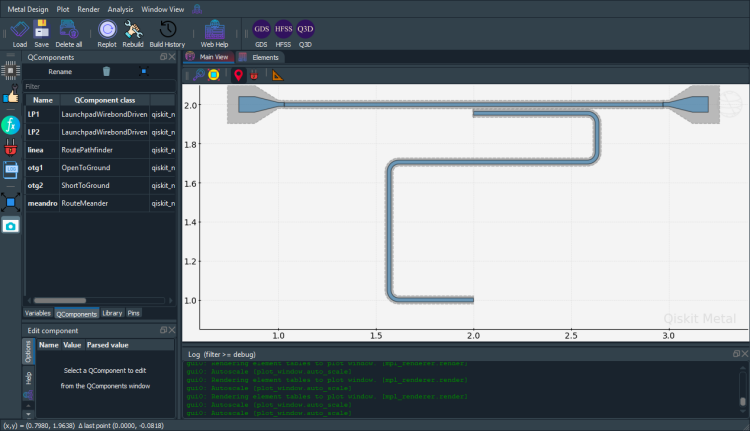

In [7]:
gui.autoscale()
gui.screenshot()

# Scattering Analysis

In [93]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [94]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [95]:
# we use HFSS as rendere
hfss = em1.renderer
hfss.start()

NameError: name 'Dispatch' is not defined

In [11]:
# Here we activate the design for a drivenmodal solution
hfss.activate_ansys_design("resonator_7", 'drivenmodal')
setup_args = Dict(max_delta_s=0.001)
setup_args.name = 'Setup'
hfss.edit_drivenmodal_setup(setup_args)

06:31PM 11s WARNING [activate_ansys_design]: The design_name=resonator_7 was not in active project.  Designs in active project are: 
['HFSSDesign1'].  A new design will be added to the project.  
INFO 06:31PM [connect_design]: 	Opened active design
	Design:    resonator_7 [Solution type: DrivenModal]
WARNING 06:31PM [connect_setup]: 	No design setup detected.
WARNING 06:31PM [connect_setup]: 	Creating drivenmodal default setup.
INFO 06:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
06:31PM 13s WARNING [edit_drivenmodal_setup]: In setup_args, key=max_delta_s, value=0.001 is not in pinfo.setup, the key/value pair from setup_args not added to Setup in Ansys.


In [12]:
# set buffer
hfss.options['x_buffer_width_mm'] = 0.4
hfss.options['y_buffer_width_mm'] = 0.4

In [13]:
# clean the design if needed
hfss.clean_active_design()

In [14]:
# render the design
hfss.render_design(selection=[], 
                   open_pins=open_terminations, 
                   port_list=port_list, 
                   box_plus_buffer = box_plus_buffer)

In [15]:
# for acurate simulations, make sure the mesh is fine enough for the meander
hfss.modeler.mesh_length(
                'cpw_mesh',
                ['trace_meandro', 'trace_linea', 'launch_pad_LP2', 'launch_pad_LP1'],
                MaxLength='0.01mm')

# Broad sweet to find the resonance

In [28]:
hfss.add_sweep(setup_name="Setup", 
               name="Sweep", 
               start_ghz=1.0,
               stop_ghz=20.0,
               count=2001,
               type="Fast")

INFO 10:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [29]:
hfss.analyze_sweep('Sweep', 'Setup')

INFO 10:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:08PM [analyze]: Analyzing setup Setup : Sweep


In [35]:
hfss.plot_params(['S11', 'S21'])

ValueError: 'S[1,1]_Re' is not in list

In [33]:
# extract the S21 parameters
freqs, Pcurves, Pparams = hfss.get_params(['S21'])

ValueError: 'S[2,1]_Re' is not in list

In [32]:
# find armin 
f_res = freqs[np.argmin(np.abs(Pparams.S21.values))]
f_res

NameError: name 'freqs' is not defined

# Narrow sweep around the resonance found above

In [ ]:
#fine sweep
hfss.add_sweep(setup_name="Setup", 
               name="Sweep_narrow", 
               start_ghz=np.round(f_res/1e9,3)-0.01,
               stop_ghz=np.round(f_res/1e9,3)+0.01,
               count=1001,
               type="Fast") #slow but precise

In [ ]:
hfss.analyze_sweep('Sweep_narrow', 'Setup')

In [ ]:
hfss.plot_params(['S11', 'S21'])

# Close connections

In [16]:
em1.close()

In [17]:
hfss.disconnect_ansys()

In [18]:
gui.main_window.close()

True

In [39]:
close()

NameError: name 'close' is not defined